# Imports

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

# Reading in Data

In [2]:
path = "../unsynced-data/catchment-analysis/"

In [3]:
# read in the shape files
rwa_cell = gpd.read_file(path + "rwa_cell/Cell.shp")
rwa_district = gpd.read_file(path + "rwa_district/District.shp")
rwa_sector = gpd.read_file(path + "rwa_sector/Sector.shp")
rwa_village = gpd.read_file(path + "rwa_villages/Village.shp")

In [4]:
bridge_sites = gpd.read_file(path + "bridge-sites.csv")
bridge_sites['Lat'] = pd.to_numeric(bridge_sites['Lat'], errors='coerce')
bridge_sites['Long'] = pd.to_numeric(bridge_sites['Long'], errors='coerce')
bridge_sites['geometry'] = bridge_sites.apply(lambda x: Point((float(x.Long), float(x.Lat))), axis=1)
bridge_sites = gpd.GeoDataFrame(bridge_sites, geometry='geometry')
bridge_sites = bridge_sites.dropna(subset=['Lat'])
bridge_sites = bridge_sites.set_crs(4326, allow_override=True)

In [5]:
data_summary = pd.read_csv(f"{path}data-summary.csv")
codes = pd.read_csv(f"{path}admin-boundary-codes.csv")
survey = pd.read_csv(f"{path}survey.csv")

# Data Cleaning

In [6]:
# switching research sites value to a boolean instead of yes/no
bridge_sites['Research Bridge'] = bridge_sites['Research Bridge'].replace('Yes', True)
bridge_sites['Research Bridge'] = bridge_sites['Research Bridge'].replace('No', False)
bridge_sites['Research Bridge'] = bridge_sites['Research Bridge'].astype(bool)

In [7]:
survey['Bridge Site'] = survey['Bridge Site'].replace('RUGESHI', 'Rugeshi')
survey['Bridge Site'] = survey['Bridge Site'].replace('Uwumugeti-kigusa', 'Uwumugeti-Kigusa')
survey['Bridge Site'].unique()

array(['Gasasa', 'Muhembe', 'Mutiwingoma', 'Nyarusange', 'Rugeshi',
       'Uwumugeti-Kigusa', 'Kanyarira', 'Gahororo', 'Ruharazi',
       'Rwamamara', 'Muregeya', 'Rwimvubu'], dtype=object)

In [8]:
# we're going to treat all admin codes as strings to avoid any issues with joins
survey['Destination - Admin Code'] = survey['Destination - Admin Code'].astype(str)
survey['Destination - Admin Code'] = survey['Destination - Admin Code'].str.replace('.0', '')
survey['Origin - Admin Code'] = survey['Origin - Admin Code'].astype(str)
survey['Origin - Admin Code'] = survey['Origin - Admin Code'].str.replace('.0', '')
survey['Home Village - Admin Code'] = survey['Home Village - Admin Code'].astype(str)
survey['Home Village - Admin Code'] = survey['Home Village - Admin Code'].str.replace('.0', '')

This chart shows the number of admin codes that are of each length for each location type. 8 characters indicates a village level admin code, 6 means it's a cell, and 4 means it's a sector, and 2 means it's a district. 3 characters means it's a "NaN" value. The reason the  number of NaN Origin codes is larger is because asking about origin (as apposed to just home village) was added later in the survey.

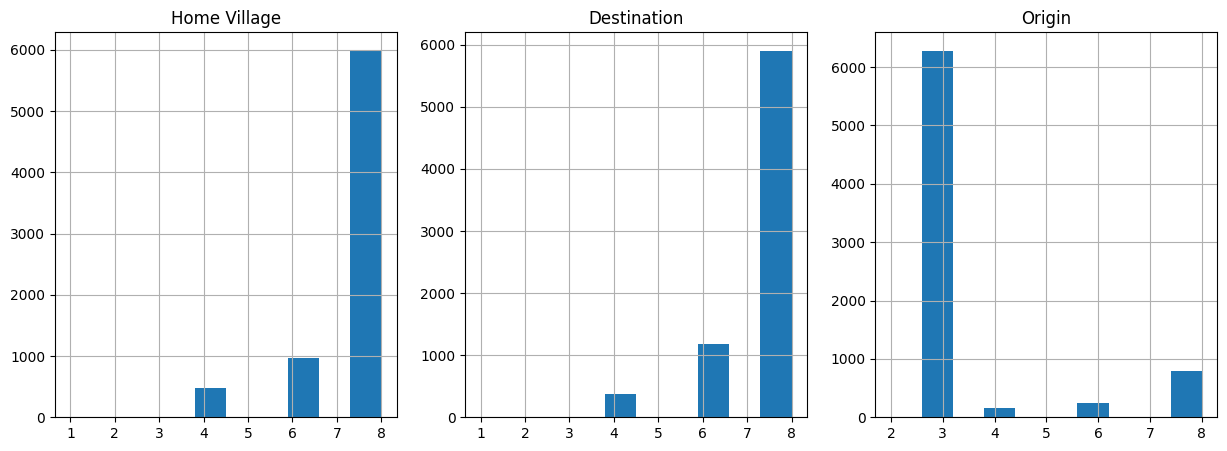

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
survey['Home Village - Admin Code'].str.len().hist(ax=ax[0])
ax[0].set_title('Home Village')
survey['Destination - Admin Code'].str.len().hist(ax=ax[1])
ax[1].set_title('Destination')
survey['Origin - Admin Code'].str.len().hist(ax=ax[2])
ax[2].set_title('Origin')
plt.show()

# Survey<> Regional Data Joins

In [10]:
rwa_village = rwa_village.to_crs(4326)
rwa_village.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# converting village codes to string
rwa_village['Village_ID'] = rwa_village['Village_ID'].astype(str)
rwa_village['Village_ID'] = rwa_village['Village_ID'].str.replace('.0', '')

In the next three cells I create a dataframe of how many times an admin code is mentioned in a column of the survey dataframe. I run this three times (once for home, once for origin, and once for destination). I join this to the rwa_village data set at each step to get the count of how many times each village is mentioned in the survey. To keep everything a managable size, I then drop any village polygons that were not mentioned at all. 

In [12]:
unique_codes = pd.DataFrame()
unique_codes['Home'] = survey['Home Village - Admin Code'].value_counts()
rwa_village = rwa_village.set_index('Village_ID').join(unique_codes)
rwa_village = rwa_village.fillna(0)

In [13]:
unique_codes = pd.DataFrame()
unique_codes['Origin'] = survey['Origin - Admin Code'].value_counts()
rwa_village = rwa_village.join(unique_codes)
rwa_village = rwa_village.fillna(0)

In [14]:
unique_codes = pd.DataFrame()
unique_codes['Destination'] = survey['Destination - Admin Code'].value_counts()
rwa_village = rwa_village.join(unique_codes)
rwa_village = rwa_village.fillna(0)

In [15]:
# if home origin and destination are all 0 then drop the row
rwa_village = rwa_village[(rwa_village['Home'] != 0) | (rwa_village['Origin'] != 0) | (rwa_village['Destination'] != 0)]
rwa_village

,District,Cell_ID,Sector_ID,Distr_ID,Prov_ID,Name,Cell,Sector,Province,geometry,Home,Origin,Destination
Village_ID,,,,,,,,,,,,,
11010202,Nyarugenge,110102,1101,11,1,Amayaga,Akabeza,Gitega,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.05544 -1.95495 0.00000, 30.0554...",1.0,0.0,1.0
11020104,Nyarugenge,110201,1102,11,1,Nyakirambi,Nyamweru,Kanyinya,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.00945 -1.90883 0.00000, 30.0095...",1.0,0.0,0.0
11020105,Nyarugenge,110201,1102,11,1,Nyamweru,Nyamweru,Kanyinya,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.01051 -1.92449 0.00000, 30.0107...",10.0,3.0,0.0
11020106,Nyarugenge,110201,1102,11,1,Ruhengeri,Nyamweru,Kanyinya,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.00919 -1.92049 0.00000, 30.0092...",0.0,0.0,1.0
11020203,Nyarugenge,110202,1102,11,1,Gateko,Nzove,Kanyinya,Kigali Town/Umujyi wa Kigali,"POLYGON Z ((30.00349 -1.92167 0.00000, 30.0036...",2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41160407,Rulindo,411604,4116,41,4,Nyarusange,Rubona,SHYORONGI,North/Amajyaruguru,"POLYGON Z ((29.95526 -1.85864 0.00000, 29.9559...",22.0,0.0,0.0
41160503,Rulindo,411605,4116,41,4,Ngendo,Rutonde,SHYORONGI,North/Amajyaruguru,"POLYGON Z ((29.98567 -1.91171 0.00000, 29.9856...",1.0,0.0,0.0
41160505,Rulindo,411605,4116,41,4,Nyabyondo,Rutonde,SHYORONGI,North/Amajyaruguru,"POLYGON Z ((29.98919 -1.90202 0.00000, 29.9892...",48.0,11.0,34.0


# Creating Catchment Radius Polygons

In [16]:
buffered_bridge_sites = bridge_sites.copy()
buffered_bridge_sites['geometry'] = buffered_bridge_sites.geometry.buffer(0.0235)
buffered_bridge_sites = buffered_bridge_sites.set_crs(4326, allow_override=True)

/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_81951/2130393474.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_bridge_sites['geometry'] = buffered_bridge_sites.geometry.buffer(0.0235)


# Data Exports

In [18]:
# Exporting Bridge and Bridge Buffers
bridge_sites.to_file(path + "output-data/bridge-sites.geojson", driver='GeoJSON')
buffered_bridge_sites.to_file(path + "output-data/buffered_bridge_sites.geojson", driver='GeoJSON')

In [17]:
# Exporting the village polygons with survey counts
rwa_village.to_file(path + "output-data/rwa_survey_villages_small.geojson", driver='GeoJSON')

# Updating Survey Data

In [ ]:
survey_data = gpd.read_file("./data/updated-survey-data.csv")
survey_data['geometry'] = gpd.points_from_xy(survey_data['GPS (Longitude)'], survey_data['GPS (Latitude)'])
survey_data = gpd.GeoDataFrame(survey_data, geometry='geometry')
survey_data = survey_data.set_crs(4326, allow_override=True)
survey_data.explore()

In [7]:
# write to geojson
survey_data.to_file("./data/survey_data_09122024.geojson", driver='GeoJSON')